In [3]:
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.3.0-posix-seh-rt_v5-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from matplotlib import rc
rc('figure', figsize=(15, 5))
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from timeit import default_timer as timer

In [3]:
def create_submission_df(pred):
    new_df = by_month.loc[:,('shop_id','item_id')]
    new_df = sales_test.merge(new_df, on = ['shop_id', 'item_id'], how = 'inner').drop(['ID'], axis = 1)
    new_df['target'] = pred
    new_df = sales_test.merge(new_df, on = ['shop_id', 'item_id'], how = 'left')
    new_df['target'].fillna(0,inplace=True)
    return(new_df)

In [4]:
def error(pred, act):
    return(np.sqrt(np.sum(np.square(np.subtract(act,pred)))/sales_test.shape[0]))

In [5]:
def create_submission_file(pred, name):
    ID = np.arange(0, sales_test.shape[0]) 
    new_df = pd.DataFrame({'ID': ID, 'item_cnt_month': pred})
    new_df.to_csv('Submission Time Series/'+name+'.csv',index = False)

In [6]:
def create_test(test):
    test = test.loc[(test['shop_id'].isin(sales_test['shop_id']))&(test['item_id'].isin(sales_test['item_id'])),:]
    test_pred = test['item_cnt_day']
    test.drop('item_cnt_day', axis = 1, inplace = True)
    return(test, test_pred)

In [7]:
def add_prev_month(m, if_test = False):
    by_month_prev = by_month.copy()
    by_month_prev.drop(['item_category_id', 'grouped_category_id'], axis = 1, inplace = True)
    cols = []
    for i in np.arange(1,m+1):
        by_month_prev['date_block_num'] = by_month['date_block_num']+i
        if not if_test:
            by_month_prev.rename({'item_cnt_day': 'prev_cnt'+str(i)}, axis = 1, inplace = True)
            by_month_prev = by_month.merge(by_month_prev, on = ['date_block_num', 'shop_id', 'item_id'], how = 'left')
            cols.append(by_month_prev['prev_cnt'+str(i)])
        else:
            sales_test_prev = sales_test_m.merge(by_month_prev, on = ['date_block_num', 'shop_id', 'item_id'], how = 'left')
            col = sales_test_prev['item_cnt_day'].rename('prev_cnt'+str(i))
            cols.append(col)
    names = [i.name for i in cols]
    mat = np.array(cols).T
    df = pd.DataFrame(mat, columns = names)
    if not if_test:
        by_month_prev = pd.concat([by_month, df], axis = 1)
    else:
        by_month_prev = pd.concat([sales_test_m, df], axis = 1)
    by_month_prev.fillna(0, inplace = True)
    return(by_month_prev)

In [8]:
def create_cv_sets(months, data):
    train = []
    test = []
    train_pred = []
    test_pred = []
    for i in months:
        x = data.loc[by_month['date_block_num']<i,:].drop('item_cnt_day', axis = 1)
        y_pred = data.loc[by_month['date_block_num']<i,'item_cnt_day']
        x_test = data.loc[by_month['date_block_num']==i,:]
        x_test = x_test.loc[(x_test['shop_id'].isin(sales_test['shop_id']))&(x_test['item_id'].isin(sales_test['item_id'])),:]
        y_test_pred = x_test['item_cnt_day']
        x_test.drop('item_cnt_day', axis = 1, inplace = True)
        train.append(x)
        test.append(x_test)
        train_pred.append(y_pred)
        test_pred.append(y_test_pred)
    return(train,test,train_pred,test_pred) 

In [96]:
def add_diff(m, data = by_month_prev):
    by_month_diff = data.copy()
    for i in np.arange(m)+1:
        by_month_diff['diff'+str(i)]=by_month_prev['prev_cnt'+str(i)]-by_month_prev['prev_cnt'+str(i+1)]
    return(by_month_diff)

In [10]:
sales_train = pd.read_csv(r'sales_train_v2.csv')
items = pd.read_csv(r'items.csv')
item_categories = pd.read_csv(r'item_categories.csv')
shops = pd.read_csv(r'shops.csv')
sales_test = pd.read_csv(r'test.csv')

In [11]:
sales_test = sales_test.loc[:, ['ID', 'shop_id', 'item_id']]

In [12]:
by_month = sales_train.groupby(['date_block_num', 'shop_id', 'item_id']).sum()['item_cnt_day'].reset_index()

In [13]:
np.unique([i.split(' ')[0] for i in item_categories['item_category_name']])

array(['PC', 'Аксессуары', 'Билеты', 'Доставка', 'Игровые', 'Игры',
       'Карты', 'Кино', 'Книги', 'Музыка', 'Подарки', 'Программы',
       'Служебные', 'Чистые', 'Элементы'], dtype='<U10')

In [14]:
item_categories['grouped_category_id'] = [i.split(' ')[0] for i in item_categories['item_category_name']]
le = LabelEncoder().fit(item_categories['grouped_category_id'])
item_categories['grouped_category_id'] = le.transform(item_categories['grouped_category_id'])

In [15]:
items = items.merge(item_categories.loc[:, ['item_category_id', 'grouped_category_id']], on = 'item_category_id', how = 'left')

In [16]:
items.head()

,item_name,item_id,item_category_id,grouped_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,7
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,11
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,7
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,7
4,***КОРОБКА (СТЕКЛО) D,4,40,7


In [17]:
by_month = by_month.merge(items.loc[:, ['item_id', 'item_category_id', 'grouped_category_id']], on = 'item_id', how = 'left')

In [18]:
by_month.head()

,date_block_num,shop_id,item_id,item_cnt_day,item_category_id,grouped_category_id
0,0,0,32,6.0,40,7
1,0,0,33,3.0,37,7
2,0,0,35,1.0,40,7
3,0,0,43,1.0,40,7
4,0,0,51,2.0,57,9


In [19]:
sales_test_m = sales_test.copy()

In [20]:
sales_test_m['ID'] = [34]*sales_test.shape[0]
sales_test_m.rename({'ID': 'date_block_num'}, axis = 1, inplace = True)
sales_test_m = sales_test_m.merge(items.loc[:, ['item_id', 'item_category_id', 'grouped_category_id']], 
                                  on = 'item_id', how = 'left')

In [21]:
sales_test_m.head()

,date_block_num,shop_id,item_id,item_category_id,grouped_category_id
0,34,5,5037,19,5
1,34,5,5320,55,9
2,34,5,5233,19,5
3,34,5,5232,23,5
4,34,5,5268,20,5


### Baseline Model

In [22]:
val_months = [28,29,30,31,32]

In [243]:
[train,test,train_pred,test_pred] = create_cv_sets(val_months,by_month)

In [252]:
rf_base = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
base_err = []
for i in range(len(train)):
    rf_base.fit(train[i], train_pred[i])
    base_err.append(error(rf_base.predict(test[i]), test_pred[i]))
    print('month %d - error %.5f' %(val_months[i], base_err[i]))
print('mean error - %.5f' %(np.mean(base_err)))

month 28 - error 3.55228
month 29 - error 2.21728
month 30 - error 0.89138
month 31 - error 1.01365
month 32 - error 1.32927
mean error - 1.80077


In [25]:
[train,test,train_pred,test_pred] = create_cv_sets([33],by_month)

In [26]:
rf_base = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
rf_base.fit(train[0], train_pred[0])
error(rf_base.predict(test[0]), test_pred[0])

4.720726170618724

### Adding 1 previous month sales 

In [71]:
by_month_prev = add_prev_month(1)
by_month_prev.head()

,date_block_num,shop_id,item_id,item_cnt_day,item_category_id,grouped_category_id,prev_cnt1
0,0,0,32,6.0,40,7,0.0
1,0,0,33,3.0,37,7,0.0
2,0,0,35,1.0,40,7,0.0
3,0,0,43,1.0,40,7,0.0
4,0,0,51,2.0,57,9,0.0


In [256]:
[train,test,train_pred,test_pred] = create_cv_sets(val_months,by_month_prev)
rf_prev = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
prev_err = []
for i in range(len(train)):
    rf_prev.fit(train[i], train_pred[i])
    prev_err.append(error(rf_prev.predict(test[i]), test_pred[i]))
    print('month %d - error %.5f' %(val_months[i], prev_err[i]))
print('mean error - %.5f' %(np.mean(prev_err)))

month 28 - error 2.89693
month 29 - error 2.26001
month 30 - error 0.96714
month 31 - error 1.10177
month 32 - error 1.45209
mean error - 1.73559


In [73]:
[train,test,train_pred,test_pred] = create_cv_sets([33],by_month_prev)
rf_prev = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
rf_prev.fit(train[0], train_pred[0])
error(rf_prev.predict(test[0]), test_pred[0])

4.641172764031045

In [74]:
sales_test_prev = add_prev_month(1, if_test = True)
sales_test_prev.head()

,date_block_num,shop_id,item_id,item_category_id,grouped_category_id,prev_cnt1
0,34,5,5037,19,5,0.0
1,34,5,5320,55,9,0.0
2,34,5,5233,19,5,1.0
3,34,5,5232,23,5,0.0
4,34,5,5268,20,5,0.0


In [80]:
pred = rf_prev.predict(sales_test_prev)

In [85]:
create_submission_file(pred, 'rf_prev_1')

### Adding 2 previous month sales 

In [139]:
by_month_prev = add_prev_month(2)

In [142]:
by_month_prev.head()

,date_block_num,shop_id,item_id,item_cnt_day,item_category_id,grouped_category_id,prev_cnt1,prev_cnt2
0,0,0,32,6.0,40,7,0.0,0.0
1,0,0,33,3.0,37,7,0.0,0.0
2,0,0,35,1.0,40,7,0.0,0.0
3,0,0,43,1.0,40,7,0.0,0.0
4,0,0,51,2.0,57,9,0.0,0.0


In [260]:
[train,test,train_pred,test_pred] = create_cv_sets(val_months,by_month_prev)

In [261]:
rf_prev_2 = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
prev_err_2 = []
for i in range(len(train)):
    rf_prev_2.fit(train[i], train_pred[i])
    prev_err_2.append(error(rf_prev_2.predict(test[i]), test_pred[i]))
    print('month %d - error %.5f' %(val_months[i], prev_err_2[i]))
print('mean error - %.5f' %(np.mean(prev_err_2)))

month 28 - error 2.93152
month 29 - error 2.15942
month 30 - error 0.92099
month 31 - error 1.03831
month 32 - error 1.39534
mean error - 1.68912


In [90]:
[train,test,train_pred,test_pred] = create_cv_sets([33],by_month_prev)

In [91]:
rf_prev_2 = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
rf_prev_2.fit(train[0], train_pred[0])
error(rf_prev_2.predict(test[0]), test_pred[0])

5.083675150192008

In [145]:
sales_test_prev = add_prev_month(2, if_test = True)
sales_test_prev.head()

,date_block_num,shop_id,item_id,item_category_id,grouped_category_id,prev_cnt1,prev_cnt2
0,34,5,5037,19,5,0.0,1.0
1,34,5,5320,55,9,0.0,0.0
2,34,5,5233,19,5,1.0,3.0
3,34,5,5232,23,5,0.0,0.0
4,34,5,5268,20,5,0.0,0.0


In [149]:
pred = rf_prev_2.predict(sales_test_prev)

In [150]:
create_submission_file(pred, 'rf_prev_2')

### Adding 3 previous month sales 

In [152]:
by_month_prev = add_prev_month(3)
by_month_prev.head()

,date_block_num,shop_id,item_id,item_cnt_day,item_category_id,grouped_category_id,prev_cnt1,prev_cnt2,prev_cnt3
0,0,0,32,6.0,40,7,0.0,0.0,0.0
1,0,0,33,3.0,37,7,0.0,0.0,0.0
2,0,0,35,1.0,40,7,0.0,0.0,0.0
3,0,0,43,1.0,40,7,0.0,0.0,0.0
4,0,0,51,2.0,57,9,0.0,0.0,0.0


In [24]:
[train,test,train_pred,test_pred] = create_cv_sets(val_months,by_month_prev)
rf_prev_3 = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
prev_err_3 = []
for i in range(len(train)):
    rf_prev_3.fit(train[i], train_pred[i])
    prev_err_3.append(error(rf_prev_3.predict(test[i]), test_pred[i]))
    print('month %d - error %.5f' %(val_months[i], prev_err_3[i]))
print('mean error - %.5f' %(np.mean(prev_err_3)))

month 28 - error 2.91102
month 29 - error 1.49512
month 30 - error 0.86104
month 31 - error 1.12077
month 32 - error 1.45817
mean error - 1.56922


In [153]:
[train,test,train_pred,test_pred] = create_cv_sets([33],by_month_prev)

In [154]:
rf_prev_3 = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
rf_prev_3.fit(train[0], train_pred[0])
error(rf_prev_3.predict(test[0]), test_pred[0])

5.1884110533608245

In [155]:
sales_test_prev = add_prev_month(3, if_test = True)
sales_test_prev.head()

,date_block_num,shop_id,item_id,item_category_id,grouped_category_id,prev_cnt1,prev_cnt2,prev_cnt3
0,34,5,5037,19,5,0.0,1.0,3.0
1,34,5,5320,55,9,0.0,0.0,0.0
2,34,5,5233,19,5,1.0,3.0,1.0
3,34,5,5232,23,5,0.0,0.0,1.0
4,34,5,5268,20,5,0.0,0.0,0.0


In [156]:
pred = rf_prev_3.predict(sales_test_prev)

In [157]:
create_submission_file(pred, 'rf_prev_3')

#### ** Seems like months over 30 are not related much with more than 1 previous months

### Adding 4 previous month sales 

In [158]:
by_month_prev = add_prev_month(4)
by_month_prev.head()

,date_block_num,shop_id,item_id,item_cnt_day,item_category_id,grouped_category_id,prev_cnt1,prev_cnt2,prev_cnt3,prev_cnt4
0,0,0,32,6.0,40,7,0.0,0.0,0.0,0.0
1,0,0,33,3.0,37,7,0.0,0.0,0.0,0.0
2,0,0,35,1.0,40,7,0.0,0.0,0.0,0.0
3,0,0,43,1.0,40,7,0.0,0.0,0.0,0.0
4,0,0,51,2.0,57,9,0.0,0.0,0.0,0.0


In [162]:
[train,test,train_pred,test_pred] = create_cv_sets(val_months,by_month_prev)
rf_prev_4 = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
prev_err_4 = []
for i in range(len(train)):
    rf_prev_4.fit(train[i], train_pred[i])
    prev_err_4.append(error(rf_prev_4.predict(test[i]), test_pred[i]))
    print('month %d - error %.5f' %(val_months[i], prev_err_4[i]))
print('mean error - %.5f' %(np.mean(prev_err_4)))

month 28 - error 2.91293
month 29 - error 1.50417
month 30 - error 0.80604
month 31 - error 1.04127
month 32 - error 1.40656
mean error - 1.53419


In [163]:
[train,test,train_pred,test_pred] = create_cv_sets([33],by_month_prev)

In [166]:
rf_prev_4 = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
rf_prev_4.fit(train[0], train_pred[0])
error(rf_prev_4.predict(test[0]), test_pred[0])

5.110434590066329

### Finding the optimum number of previous months

In [23]:
prev_err_opt = []
prev_err_test = []
for j in np.arange(5,13):
    print('Number of previous months: %d' %(j))
    by_month_prev = add_prev_month(j)
    [train,test,train_pred,test_pred] = create_cv_sets(val_months,by_month_prev)
    rf_prev_opt = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
    err =  []
    for i in range(len(train)):
        rf_prev_opt.fit(train[i], train_pred[i])
        err.append(error(rf_prev_opt.predict(test[i]), test_pred[i]))
        print('month %d - error %.5f' %(val_months[i], err[i]))
    print('---->mean error - %.5f' %(np.mean(err)))
    prev_err_opt.append(err)
    
    [train,test,train_pred,test_pred] = create_cv_sets([33],by_month_prev)
    rf_prev_test = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
    rf_prev_test.fit(train[0], train_pred[0])
    err_test = error(rf_prev_test.predict(test[0]), test_pred[0])
    prev_err_test.append(err_test)
    print('---->test error - %.5f' %(err_test))

Number of previous months: 5
month 28 - error 2.81213
month 29 - error 1.29434
month 30 - error 0.89061
month 31 - error 1.07408
month 32 - error 1.43215
---->mean error - 1.50066
---->test error - 4.80254
Number of previous months: 6
month 28 - error 2.69452
month 29 - error 1.47860
month 30 - error 0.98381
month 31 - error 1.04382
month 32 - error 1.37531
---->mean error - 1.51521
---->test error - 4.80783
Number of previous months: 7
month 28 - error 2.71304
month 29 - error 1.48447
month 30 - error 0.93602
month 31 - error 1.01396
month 32 - error 1.36379
---->mean error - 1.50225
---->test error - 4.84367
Number of previous months: 8
month 28 - error 2.82987
month 29 - error 1.43500
month 30 - error 1.16965
month 31 - error 1.07490
month 32 - error 1.39844
---->mean error - 1.58157
---->test error - 4.83463
Number of previous months: 9
month 28 - error 2.83748
month 29 - error 1.38862
month 30 - error 1.12903
month 31 - error 1.09326
month 32 - error 1.41433
---->mean error - 1.57

In [43]:
mean_err_opt = [1.735, 1.689, 1.569, 1.534]
mean_err_opt.extend(np.mean(prev_err_opt, axis = 1).tolist())

In [46]:
test_err = [4.641, 5.083, 5.188, 5.110]
test_err.extend(prev_err_test)

Text(0,0.5,'RMSE')

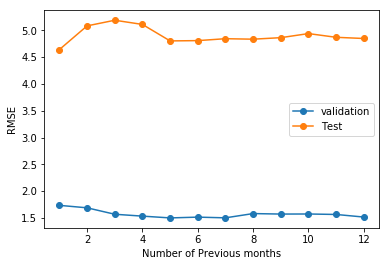

In [56]:
plt.plot(np.arange(len(mean_err_opt))+1, mean_err_opt, marker = 'o')
plt.plot(np.arange(len(test_err))+1, test_err, marker = 'o')
plt.legend(['validation', 'Test'])
plt.xlabel('Number of Previous months')
plt.ylabel('RMSE')

#### ** 5 previous months are optimum

### Adding differences 

In [26]:
by_month_prev = add_prev_month(5)

In [84]:
by_month_diff = add_diff(1)

In [86]:
[train,test,train_pred,test_pred] = create_cv_sets(val_months,by_month_diff)
rf_prev_diff = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
prev_err_diff = []
for i in range(len(train)):
    rf_prev_diff.fit(train[i], train_pred[i])
    prev_err_diff.append(error(rf_prev_diff.predict(test[i]), test_pred[i]))
    print('month %d - error %.5f' %(val_months[i], prev_err_diff[i]))
print('mean error - %.5f' %(np.mean(prev_err_diff)))

month 28 - error 2.84137
month 29 - error 1.34319
month 30 - error 0.89283
month 31 - error 1.05895
month 32 - error 1.41600
mean error - 1.51046


In [87]:
[train,test,train_pred,test_pred] = create_cv_sets([33],by_month_diff)

In [90]:
start = timer()
rf_prev_diff = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
rf_prev_diff.fit(train[0], train_pred[0])
print('total time: %.5f' %(timer()-start))
error(rf_prev_diff.predict(test[0]), test_pred[0])

total time: 190.32013


5.112846652928145

#### Comparing timing with catboost

In [106]:
cat_features = [1,2,3,4]
start = timer()
cat_diff = CatBoostRegressor(iterations = 3000, l2_leaf_reg = 2, depth = 2, 
                           one_hot_max_size=2, rsm = 1, thread_count = 4, learning_rate = 0.1, metric_period = 50)
cat_diff.fit(train[0].values, train_pred[0].values, cat_features = cat_features, early_stopping_rounds=200, 
             eval_set=(test[0].values, test_pred[0].values)) 
print('total time: %.5f' %(timer()-start))


0:	learn: 8.4318635	test: 14.7853321	best: 14.7853321 (0)	total: 699ms	remaining: 34m 55s
50:	learn: 5.7755249	test: 12.9520640	best: 12.9499696 (45)	total: 15s	remaining: 14m 25s
100:	learn: 5.6764437	test: 12.6876368	best: 12.6779742 (87)	total: 29.1s	remaining: 13m 56s
150:	learn: 5.6128217	test: 12.5580507	best: 12.5580507 (150)	total: 44.5s	remaining: 14m
200:	learn: 5.5702661	test: 12.3623441	best: 12.3576128 (191)	total: 58.9s	remaining: 13m 39s
250:	learn: 5.5359352	test: 12.1036631	best: 12.0942814 (243)	total: 1m 14s	remaining: 13m 32s
300:	learn: 5.5121058	test: 12.0132547	best: 12.0132547 (300)	total: 1m 29s	remaining: 13m 21s
350:	learn: 5.4873184	test: 11.9467962	best: 11.9451531 (348)	total: 1m 44s	remaining: 13m 5s
400:	learn: 5.4647444	test: 11.8691145	best: 11.8532445 (391)	total: 1m 59s	remaining: 12m 56s
450:	learn: 5.4460086	test: 11.7983957	best: 11.7857573 (448)	total: 2m 14s	remaining: 12m 41s
500:	learn: 5.4290140	test: 11.8101760	best: 11.7857573 (448)	total: 

AttributeError: 'list' object has no attribute 'values'

In [107]:
pred = cat_diff.predict(test[0].values)
error(pred, test_pred[0])

4.2377820776374175

#### Since, catoost takes almost double the time, let's stick to rf

### Adding 2 month differences

In [112]:
by_month_diff = add_diff(2)

In [115]:
[train,test,train_pred,test_pred] = create_cv_sets(val_months,by_month_diff)
rf_prev_diff2 = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
prev_err_diff2 = []
for i in range(len(train)):
    rf_prev_diff2.fit(train[i], train_pred[i])
    prev_err_diff2.append(error(rf_prev_diff2.predict(test[i]), test_pred[i]))
    print('month %d - error %.5f' %(val_months[i], prev_err_diff2[i]))
print('mean error - %.5f' %(np.mean(prev_err_diff2)))

month 28 - error 2.83720
month 29 - error 1.29068
month 30 - error 0.89308
month 31 - error 1.04541
month 32 - error 1.42188
mean error - 1.49765


In [116]:
[train,test,train_pred,test_pred] = create_cv_sets([33],by_month_diff)

In [117]:
start = timer()
rf_prev_diff2 = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
rf_prev_diff2.fit(train[0], train_pred[0])
print('total time: %.5f' %(timer()-start))
error(rf_prev_diff2.predict(test[0]), test_pred[0])

total time: 198.34587


4.944233412506764

### Adding 3 month differences

In [118]:
by_month_diff = add_diff(3)

In [119]:
[train,test,train_pred,test_pred] = create_cv_sets(val_months,by_month_diff)
rf_prev_diff3 = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
prev_err_diff3 = []
for i in range(len(train)):
    rf_prev_diff3.fit(train[i], train_pred[i])
    prev_err_diff3.append(error(rf_prev_diff3.predict(test[i]), test_pred[i]))
    print('month %d - error %.5f' %(val_months[i], prev_err_diff3[i]))
print('mean error - %.5f' %(np.mean(prev_err_diff3)))

month 28 - error 2.84033
month 29 - error 1.32877
month 30 - error 0.88898
month 31 - error 1.04066
month 32 - error 1.42330
mean error - 1.50441


In [120]:
[train,test,train_pred,test_pred] = create_cv_sets([33],by_month_diff)

In [121]:
start = timer()
rf_prev_diff3 = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
rf_prev_diff3.fit(train[0], train_pred[0])
print('total time: %.5f' %(timer()-start))
error(rf_prev_diff3.predict(test[0]), test_pred[0])

total time: 209.83999


5.107486928841944

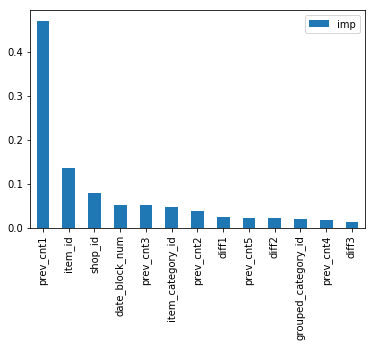

In [129]:
pd.DataFrame(index =  train[0].columns.tolist(), 
              data = {'imp':rf_prev_diff3.feature_importances_}).sort_values('imp', ascending = False).plot(kind = 'bar')

### Adding 4 month differences

In [130]:
by_month_diff = add_diff(4)

In [131]:
[train,test,train_pred,test_pred] = create_cv_sets(val_months,by_month_diff)
rf_prev_diff4 = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
prev_err_diff4 = []
for i in range(len(train)):
    rf_prev_diff4.fit(train[i], train_pred[i])
    prev_err_diff4.append(error(rf_prev_diff4.predict(test[i]), test_pred[i]))
    print('month %d - error %.5f' %(val_months[i], prev_err_diff4[i]))
print('mean error - %.5f' %(np.mean(prev_err_diff4)))

month 28 - error 2.84788
month 29 - error 1.31015
month 30 - error 0.89730
month 31 - error 1.04485
month 32 - error 1.42333
mean error - 1.50470


In [132]:
[train,test,train_pred,test_pred] = create_cv_sets([33],by_month_diff)

In [133]:
start = timer()
rf_prev_diff4 = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
rf_prev_diff4.fit(train[0], train_pred[0])
print('total time: %.5f' %(timer()-start))
error(rf_prev_diff4.predict(test[0]), test_pred[0])

total time: 224.15928


4.956354634066936

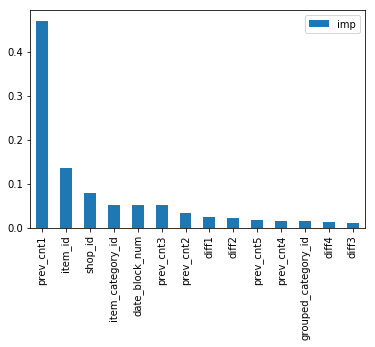

In [134]:
pd.DataFrame(index =  train[0].columns.tolist(), 
              data = {'imp':rf_prev_diff4.feature_importances_}).sort_values('imp', ascending = False).plot(kind = 'bar')

#### ** Keep all the differences

### Add frequencies

#### Item frequencies

In [27]:
full_set = pd.concat([by_month.drop('item_cnt_day', axis = 1), sales_test_m])

In [28]:
item_freq = full_set.groupby('item_id').size().rename('item_freq')

In [29]:
by_month_diff = add_diff(4)
by_month_item = by_month_diff.copy()
by_month_item = by_month_item.join(item_freq, on = 'item_id')

In [151]:
[train,test,train_pred,test_pred] = create_cv_sets(val_months,by_month_item)
rf_item = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
item_err = []
for i in range(len(train)):
    rf_item.fit(train[i], train_pred[i])
    item_err.append(error(rf_item.predict(test[i]), test_pred[i]))
    print('month %d - error %.5f' %(val_months[i], item_err[i]))
print('mean error - %.5f' %(np.mean(item_err)))

month 28 - error 2.84063
month 29 - error 1.37937
month 30 - error 0.88843
month 31 - error 1.05610
month 32 - error 1.34345
mean error - 1.50160


In [152]:
[train,test,train_pred,test_pred] = create_cv_sets([33],by_month_item)

In [153]:
start = timer()
rf_item = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
rf_item.fit(train[0], train_pred[0])
print('total time: %.5f' %(timer()-start))
error(rf_item.predict(test[0]), test_pred[0])

total time: 257.62702


4.579282446776744

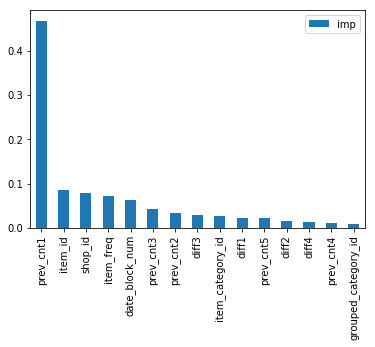

In [154]:
pd.DataFrame(index =  train[0].columns.tolist(), 
              data = {'imp':rf_item.feature_importances_}).sort_values('imp', ascending = False).plot(kind = 'bar')

#### Item and Shop frequencies

In [30]:
shop_freq = full_set.groupby('shop_id').size().rename('shop_freq')

In [31]:
by_month_item_shop = by_month_item.copy()
by_month_item_shop = by_month_item.join(shop_freq, on = 'shop_id')

In [161]:
[train,test,train_pred,test_pred] = create_cv_sets(val_months,by_month_item_shop)
rf_item_shop = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
item_shop_err = []
for i in range(len(train)):
    rf_item_shop.fit(train[i], train_pred[i])
    item_shop_err.append(error(rf_item_shop.predict(test[i]), test_pred[i]))
    print('month %d - error %.5f' %(val_months[i], item_shop_err[i]))
print('mean error - %.5f' %(np.mean(item_shop_err)))

month 28 - error 2.81749
month 29 - error 1.34576
month 30 - error 0.91892
month 31 - error 1.10659
month 32 - error 1.33207
mean error - 1.50417


In [162]:
[train,test,train_pred,test_pred] = create_cv_sets([33],by_month_item_shop)

In [163]:
start = timer()
rf_item_shop = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
rf_item_shop.fit(train[0], train_pred[0])
print('total time: %.5f' %(timer()-start))
error(rf_item_shop.predict(test[0]), test_pred[0])

total time: 285.20895


4.522403644378626

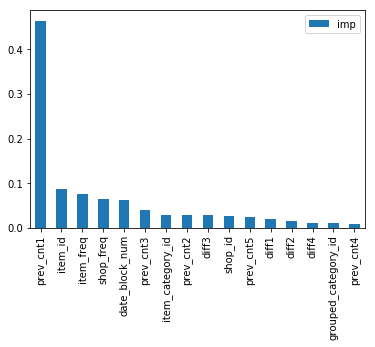

In [164]:
pd.DataFrame(index =  train[0].columns.tolist(), 
              data = {'imp':rf_item_shop.feature_importances_}).sort_values('imp', ascending = False).plot(kind = 'bar')

#### Item, Shop and ItemCat_shop frequencies

In [32]:
itcat_freq = full_set.groupby(['shop_id','item_category_id']).size().rename('itcat_shop_freq')

In [35]:
by_month_freq = by_month_item_shop.copy()
by_month_freq = by_month_freq.join(itcat_freq, on = ['shop_id', 'item_category_id'])

In [37]:
[train,test,train_pred,test_pred] = create_cv_sets(val_months,by_month_freq)
rf_freq = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
freq_err = []
for i in range(len(train)):
    rf_freq.fit(train[i], train_pred[i])
    freq_err.append(error(rf_freq.predict(test[i]), test_pred[i]))
    print('month %d - error %.5f' %(val_months[i], freq_err[i]))
print('mean error - %.5f' %(np.mean(freq_err)))

month 28 - error 2.81858
month 29 - error 1.27240
month 30 - error 0.88377
month 31 - error 1.13091
month 32 - error 1.34225
mean error - 1.48958


In [38]:
[train,test,train_pred,test_pred] = create_cv_sets([33],by_month_freq)

In [39]:
start = timer()
rf_freq = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
rf_freq.fit(train[0], train_pred[0])
print('total time: %.5f' %(timer()-start))
error(rf_freq.predict(test[0]), test_pred[0])

total time: 322.82246


4.532187973204898

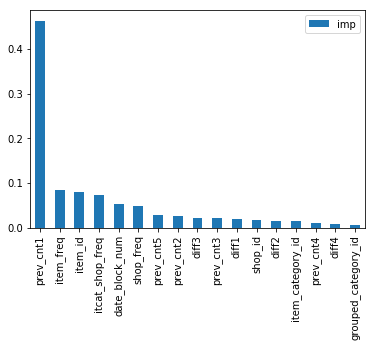

In [40]:
pd.DataFrame(index =  train[0].columns.tolist(), 
              data = {'imp':rf_freq.feature_importances_}).sort_values('imp', ascending = False).plot(kind = 'bar')

### Adding item category wise sum, max, min, mean and standard deviations

In [53]:
date_itcat = by_month.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_day': ['max', 'mean', 'min', 'sum', 'std']}).fillna(0)
date_itcat.columns = ['cat_max', 'cat_mean', 'cat_min', 'cat_sum', 'cat_std']

In [60]:
by_month_catstat = by_month_freq.copy()
by_month_catstat = by_month_freq.join(date_itcat, on = ['date_block_num', 'item_category_id'])

In [61]:
[train,test,train_pred,test_pred] = create_cv_sets(val_months,by_month_catstat)
rf_catstat = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
catstat_err = []
for i in range(len(train)):
    rf_catstat.fit(train[i], train_pred[i])
    catstat_err.append(error(rf_catstat.predict(test[i]), test_pred[i]))
    print('month %d - error %.5f' %(val_months[i], catstat_err[i]))
print('mean error - %.5f' %(np.mean(catstat_err)))

month 28 - error 2.58829
month 29 - error 0.95729
month 30 - error 0.77888
month 31 - error 0.93449
month 32 - error 1.27518
mean error - 1.30683


In [83]:
[train,test,train_pred,test_pred] = create_cv_sets([33],by_month_catstat)

In [63]:
start = timer()
rf_catstat = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
rf_catstat.fit(train[0], train_pred[0])
print('total time: %.5f' %(timer()-start))
error(rf_catstat.predict(test[0]), test_pred[0])

total time: 397.79777


4.357898212984545

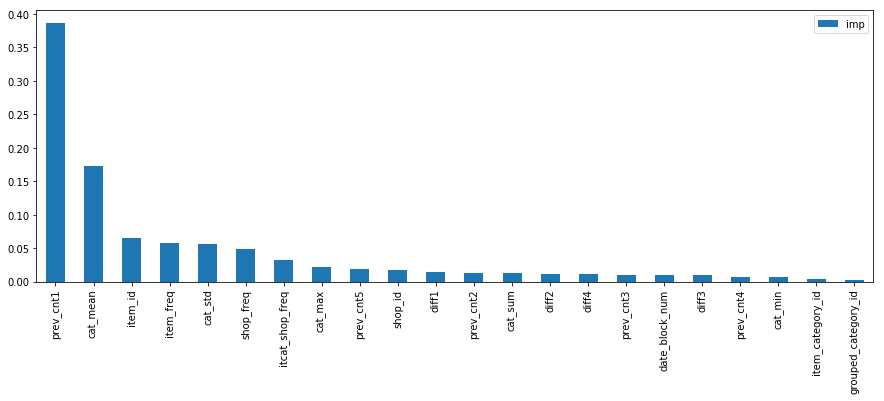

In [84]:
pd.DataFrame(index =  train[0].columns.tolist(), 
              data = {'imp':rf_catstat.feature_importances_}).sort_values('imp', ascending = False).plot(kind = 'bar')

### Adding shop statistics

In [69]:
date_shop = by_month.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_day': ['max', 'mean', 'min', 'sum', 'std']}).fillna(0)
date_shop.columns = ['shop_max', 'shop_mean', 'shop_min', 'shop_sum', 'shop_std']

In [70]:
by_month_catshopstat = by_month_catstat.copy()
by_month_catshopstat = by_month_catstat.join(date_shop, on = ['date_block_num', 'shop_id'])

In [76]:
[train,test,train_pred,test_pred] = create_cv_sets(val_months,by_month_catshopstat)
rf_catshopstat = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
catshopstat_err = []
for i in range(len(train)):
    rf_catshopstat.fit(train[i], train_pred[i])
    catshopstat_err.append(error(rf_catshopstat.predict(test[i]), test_pred[i]))
    print('month %d - error %.5f' %(val_months[i], catshopstat_err[i]))
print('mean error - %.5f' %(np.mean(catshopstat_err)))

month 28 - error 2.58518
month 29 - error 0.87252
month 30 - error 0.64479
month 31 - error 0.78824
month 32 - error 1.27437
mean error - 1.23302


In [77]:
[train,test,train_pred,test_pred] = create_cv_sets([33],by_month_catshopstat)

In [78]:
start = timer()
rf_catshopstat = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
rf_catshopstat.fit(train[0], train_pred[0])
print('total time: %.5f' %(timer()-start))
error(rf_catshopstat.predict(test[0]), test_pred[0])

total time: 525.07848


4.577598893756367

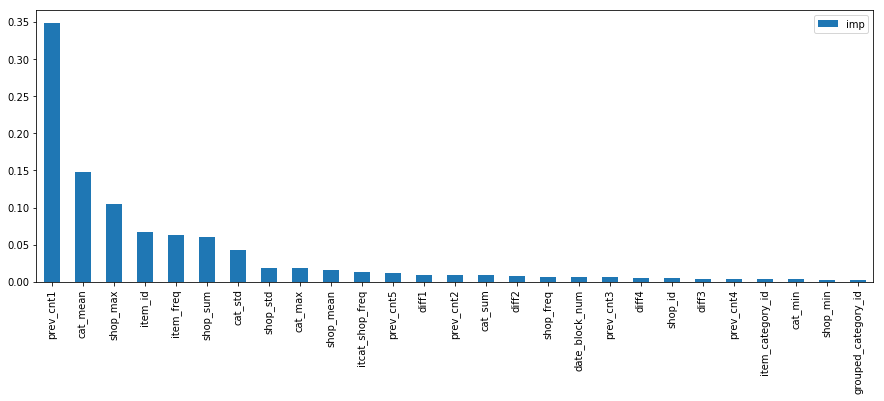

In [81]:
pd.DataFrame(index =  train[0].columns.tolist(), 
              data = {'imp':rf_catshopstat.feature_importances_}).sort_values('imp', ascending = False).plot(kind = 'bar')

### Adding item statistics

In [87]:
date_item = by_month.groupby(['date_block_num','item_id']).agg({'item_cnt_day': ['max', 'mean', 'min', 'sum', 'std']}).fillna(0)
date_item.columns = ['item_max', 'item_mean', 'item_min', 'item_sum', 'item_std']

In [88]:
by_month_catshopitemstat = by_month_catshopstat.copy()
by_month_catshopitemstat = by_month_catshopstat.join(date_item, on = ['date_block_num', 'item_id'])

In [90]:
[train,test,train_pred,test_pred] = create_cv_sets(val_months,by_month_catshopitemstat)
rf_catshopitemstat = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
catshopitemstat_err = []
for i in range(len(train)):
    rf_catshopitemstat.fit(train[i], train_pred[i])
    catshopitemstat_err.append(error(rf_catshopitemstat.predict(test[i]), test_pred[i]))
    print('month %d - error %.5f' %(val_months[i], catshopitemstat_err[i]))
print('mean error - %.5f' %(np.mean(catshopitemstat_err)))

month 28 - error 1.09465
month 29 - error 0.59951
month 30 - error 0.55542
month 31 - error 0.57921
month 32 - error 0.73286
mean error - 0.71233


In [91]:
[train,test,train_pred,test_pred] = create_cv_sets([33],by_month_catshopitemstat)

In [92]:
start = timer()
rf_catshopitemstat = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
rf_catshopitemstat.fit(train[0], train_pred[0])
print('total time: %.5f' %(timer()-start))
error(rf_catshopitemstat.predict(test[0]), test_pred[0])

total time: 606.36634


2.0256516586990694

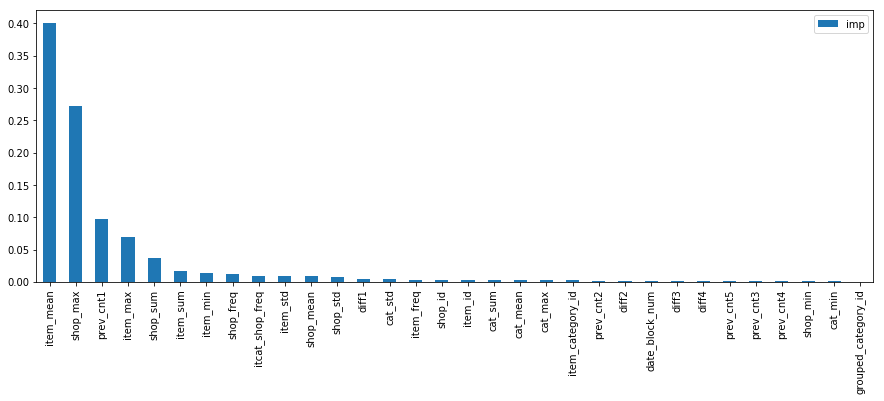

In [93]:
pd.DataFrame(index =  train[0].columns.tolist(), 
              data = {'imp':rf_catshopitemstat.feature_importances_}).sort_values('imp', ascending = False).plot(kind = 'bar')

#### Submitting 

In [94]:
sales_test_prev = add_prev_month(5, if_test=True)
sales_test_prev = add_diff(4, data=sales_test_prev)
sales_test_prev = sales_test_prev.join(item_freq, on = 'item_id')
sales_test_prev = sales_test_prev.join(shop_freq, on = 'shop_id')
sales_test_prev = sales_test_prev.join(itcat_freq, on  = ['shop_id', 'item_category_id'])
sales_test_prev = sales_test_prev.join(date_itcat, on = ['date_block_num', 'item_category_id'])
sales_test_prev = sales_test_prev.join(date_shop, on = ['date_block_num', 'shop_id'])
sales_test_prev = sales_test_prev.join(date_item, on = ['date_block_num', 'item_id'])
sales_test_prev.fillna(0, inplace = True)

In [113]:
sales_test_prev.shape

(214200, 32)

In [114]:
pred = rf_catshopitemstat.predict(sales_test_prev)

In [115]:
create_submission_file(pred, 'rf_catshopitemstat')

### Adding ewms

In [118]:
sales_pivot = by_month.pivot_table(values = 'item_cnt_day', columns = 'date_block_num', index = ['shop_id', 'item_id'],
                                  aggfunc = 'sum', fill_value = 0)

In [120]:
ewms26 = sales_pivot.ewm(span = 26, axis = 1).mean()
ewms12 = sales_pivot.ewm(span = 12, axis = 1).mean()
macd = ewms26-ewms12
sig = macd.ewm(span = 9, axis = 1).mean()

In [188]:
sig_list = []
macd_list = []
for col in sig.columns.tolist():
    sig_list.append(full_set.loc[full_set['date_block_num']==col+1,
                                 :].join(sig[col], on = ['shop_id', 'item_id']).loc[:,['date_block_num','shop_id','item_id', col]].rename({'col': 'sig_'+str(col)}))
    macd_list.append(full_set.loc[full_set['date_block_num']==col+1,
                                 :].join(macd[col], on = ['shop_id', 'item_id']).loc[:,['date_block_num','shop_id','item_id', col]].rename({'col': 'macd_'+str(col)}))

In [192]:
sig_df = pd.DataFrame(data = np.vstack(sig_list), columns = ['date_block_num', 'shop_id','item_id', 'sig_prev'])
macd_df = pd.DataFrame(data = np.vstack(macd_list), columns = ['date_block_num', 'shop_id','item_id', 'macd_prev'])

In [198]:
by_month_ewms = by_month_catshopitemstat.copy()
by_month_ewms = by_month_ewms.merge(sig_df, on = ['date_block_num', 'shop_id','item_id'], how = 'left')
by_month_ewms = by_month_ewms.merge(macd_df, on = ['date_block_num', 'shop_id','item_id'], how = 'left')
by_month_ewms.fillna(0, inplace = True)

In [204]:
[train,test,train_pred,test_pred] = create_cv_sets(val_months,by_month_ewms)
rf_ewms = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
ewms_err = []
for i in range(len(train)):
    rf_ewms.fit(train[i], train_pred[i])
    ewms_err.append(error(rf_ewms.predict(test[i]), test_pred[i]))
    print('month %d - error %.5f' %(val_months[i], ewms_err[i]))
print('mean error - %.5f' %(np.mean(ewms_err)))

month 28 - error 1.13085
month 29 - error 0.61833
month 30 - error 0.59923
month 31 - error 0.57868
month 32 - error 0.72657
mean error - 0.73073


In [205]:
[train,test,train_pred,test_pred] = create_cv_sets([33],by_month_ewms)

In [206]:
start = timer()
rf_ewms = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 24)
rf_ewms.fit(train[0], train_pred[0])
print('total time: %.5f' %(timer()-start))
error(rf_ewms.predict(test[0]), test_pred[0])

total time: 704.85171


2.001454588223481

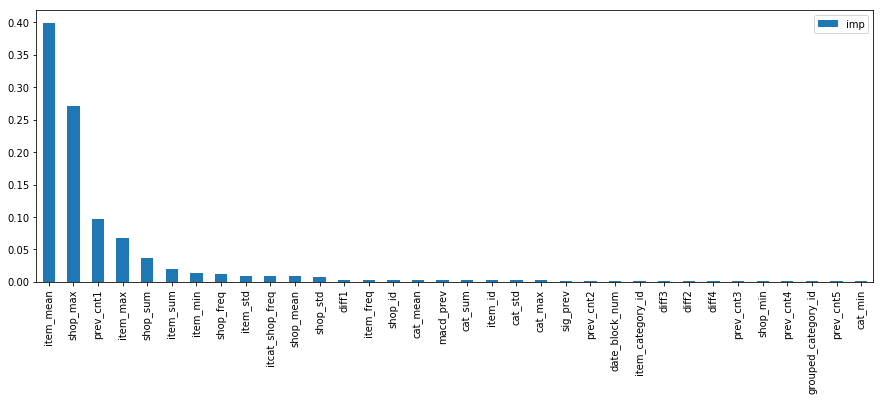

In [207]:
pd.DataFrame(index =  train[0].columns.tolist(), 
              data = {'imp':rf_ewms.feature_importances_}).sort_values('imp', ascending = False).plot(kind = 'bar')

### Applying CatBoost

In [232]:
cat_features = [1,2,3,4]
start = timer()
cat_ewms = CatBoostRegressor(iterations = 3000, l2_leaf_reg = 2, depth = 2, 
                           one_hot_max_size=20, rsm = 1, thread_count = 4, learning_rate = 0.1, metric_period = 50)
cat_ewms.fit(train[0].values, train_pred[0].values, cat_features = cat_features, early_stopping_rounds=200, 
             eval_set=(test[0].values, test_pred[0].values)) 
print('total time: %.5f' %(timer()-start))


0:	learn: 8.2865410	test: 14.6522348	best: 14.6522348 (0)	total: 495ms	remaining: 24m 43s
50:	learn: 3.8300992	test: 7.6992861	best: 7.6992852 (49)	total: 17.9s	remaining: 17m 12s
100:	learn: 3.4183849	test: 6.5975460	best: 6.5975460 (100)	total: 35.1s	remaining: 16m 46s
150:	learn: 3.2597006	test: 6.3848799	best: 6.3678611 (136)	total: 51.9s	remaining: 16m 18s
200:	learn: 3.1425580	test: 6.0187195	best: 6.0187195 (200)	total: 1m 8s	remaining: 15m 52s
250:	learn: 3.0537661	test: 5.8547527	best: 5.8547527 (250)	total: 1m 25s	remaining: 15m 32s
300:	learn: 2.9919891	test: 5.9308969	best: 5.8547527 (250)	total: 1m 41s	remaining: 15m 14s
350:	learn: 2.9469669	test: 5.9554877	best: 5.8547527 (250)	total: 1m 58s	remaining: 14m 55s
400:	learn: 2.8932218	test: 5.8806593	best: 5.8546910 (393)	total: 2m 15s	remaining: 14m 36s
450:	learn: 2.8438027	test: 5.9328417	best: 5.8366419 (432)	total: 2m 31s	remaining: 14m 17s
500:	learn: 2.8080613	test: 5.8926586	best: 5.8366419 (432)	total: 2m 47s	remai

In [233]:
pred = cat_ewms.predict(test[0].values)

In [234]:
error(pred, test_pred[0])

2.1357129913535657

In [224]:
sales_test_ewms = sales_test_prev.merge(sig_df, on = ['date_block_num', 'shop_id','item_id'], how = 'left')
sales_test_ewms = sales_test_ewms.merge(macd_df, on = ['date_block_num', 'shop_id','item_id'], how = 'left')

In [221]:
sales_test_ewms.fillna(0, inplace = True)
pred_test = cat_ewms.predict(sales_test_ewms.values)

In [223]:
create_submission_file(pred_test, 'catboost_ewms')

In [226]:
nulls = sales_test_ewms['sig_prev'].isnull()

In [228]:
pred_test[nulls] = 0

In [230]:
create_submission_file(pred_test, 'catboost_ewms_wonull')

### Hyperparameter tuning

In [237]:
import hyperopt
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
import seaborn as sns
from timeit import default_timer as timer
from numpy.random import RandomState
from hyperopt import STATUS_OK
import csv
import ast

In [255]:
[train,test,train_pred,test_pred] = create_cv_sets([31,32], by_month_ewms)

In [256]:
def objective(params):
    global ITERATION
    ITERATION +=1
    print('ITERATION: %d' %(ITERATION))
    model = CatBoostRegressor(iterations = 3000, l2_leaf_reg=params['l2_leaf_reg'], learning_rate = params['learning_rate'],
                             rsm = params['rsm'], random_seed = 42, thread_count = 4, 
                              depth = params['depth'], one_hot_max_size = params['one_hot_max_size'])
    start = timer()
    srtc = []
    for i in range(len(train)):
        model.fit(train[i], train_pred[i], eval_set = (test[i], test_pred[i]), cat_features = cat_features, 
                  early_stopping_rounds=200, logging_level = 'Silent')
        pred = model.predict(test[i].values)
        srtc.append(error(pred, test_pred[i]))
    train_time = timer()-start
    loss = np.mean(srtc)
    print('loss: %.5f' %(loss))
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([ITERATION, loss, params, train_time])
    return {'iteration': ITERATION, 'loss': loss, 'params': params,   
            'train_time': train_time, 'status': STATUS_OK}

In [257]:
params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', np.log(1), np.log(100), 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
    'rsm': 1 - hp.loguniform('rsm',np.log(0.05) , np.log(1)),
    'depth': hp.quniform('depth', 1, 10, 1),
    'one_hot_max_size': hp.choice('one_hot_max_size',[2,20])
}

In [258]:
sample(params_space)

{'depth': 8.0,
 'l2_leaf_reg': 88.0,
 'learning_rate': 0.08779723973143137,
 'one_hot_max_size': 2,
 'rsm': 0.925746191816492}

In [239]:
out_file = 'cat_trials2.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['iteration', 'loss', 'params', 'train_time'])
of_connection.close()

In [259]:
trials = hyperopt.Trials()
global  ITERATION
ITERATION = 0
best = hyperopt.fmin(
    objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=70,
    trials=trials,
    rstate=RandomState(123)
)

ITERATION: 1
loss: 0.71365
ITERATION: 2
loss: 0.65326
ITERATION: 3
loss: 0.84319
ITERATION: 4
loss: 0.69346
ITERATION: 5
loss: 0.77932
ITERATION: 6
loss: 0.75894
ITERATION: 7
loss: 0.68272
ITERATION: 8
loss: 0.66004
ITERATION: 9
loss: 0.77116
ITERATION: 10
loss: 0.79772
ITERATION: 11
loss: 0.76217
ITERATION: 12
loss: 0.64633
ITERATION: 13
loss: 0.64930
ITERATION: 14
loss: 0.79728
ITERATION: 15
loss: 0.71976
ITERATION: 16
loss: 0.68199
ITERATION: 17
loss: 0.87219
ITERATION: 18
loss: 0.98696
ITERATION: 19
loss: 0.78444
ITERATION: 20


KeyboardInterrupt: 

In [261]:
results = pd.read_csv('cat_trials2.csv')
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.rename({'n_estimators': 'train_time'}, axis = 1, inplace = True)
results.head()

,iteration,loss,params,train_time
0,12,0.646333,"{'depth': 5.0, 'l2_leaf_reg': 2.0, 'learning_r...",5113.342901
1,13,0.649296,"{'depth': 6.0, 'l2_leaf_reg': 2.0, 'learning_r...",7315.796317
2,2,0.653256,"{'depth': 5.0, 'l2_leaf_reg': 3.0, 'learning_r...",3574.988559
3,8,0.660037,"{'depth': 5.0, 'l2_leaf_reg': 12.0, 'learning_...",3416.176511
4,16,0.681995,"{'depth': 6.0, 'l2_leaf_reg': 13.0, 'learning_...",5072.312344


In [262]:
best_params = ast.literal_eval(results.loc[0, 'params'])

In [263]:
best_params

{'depth': 5.0,
 'l2_leaf_reg': 2.0,
 'learning_rate': 0.06218462935144204,
 'one_hot_max_size': 20,
 'rsm': 0.9492290749219809}

In [264]:
[train,test,train_pred,test_pred] = create_cv_sets([33],by_month_ewms)

In [269]:
cat_features = [1,2,3,4]
start = timer()
cat_tuned = CatBoostRegressor(iterations = 3000, l2_leaf_reg = 2, depth = 2, 
                           one_hot_max_size=20, rsm = 1, thread_count = 4, learning_rate = 0.1, metric_period = 50)
cat_tuned.fit(train[0].values, train_pred[0].values, cat_features = cat_features, early_stopping_rounds=400, 
             eval_set=(test[0].values, test_pred[0].values)) 
print('total time: %.5f' %(timer()-start))


0:	learn: 8.3555608	test: 14.9218338	best: 14.9218338 (0)	total: 437ms	remaining: 21m 49s
50:	learn: 3.7568966	test: 7.8038811	best: 7.8038811 (50)	total: 17s	remaining: 16m 21s
100:	learn: 3.3632724	test: 6.5773384	best: 6.5771433 (97)	total: 33.7s	remaining: 16m 6s
150:	learn: 3.2010540	test: 6.3219408	best: 6.3111810 (148)	total: 50.3s	remaining: 15m 48s
200:	learn: 3.1048713	test: 6.1461771	best: 6.1461771 (200)	total: 1m 7s	remaining: 15m 40s
250:	learn: 3.0014098	test: 6.0000013	best: 6.0000013 (250)	total: 1m 24s	remaining: 15m 22s
300:	learn: 2.9437080	test: 5.8906813	best: 5.8706079 (291)	total: 1m 40s	remaining: 15m 3s
350:	learn: 2.8869821	test: 5.8639367	best: 5.7798367 (330)	total: 1m 56s	remaining: 14m 41s
400:	learn: 2.8376385	test: 5.7043856	best: 5.6636543 (388)	total: 2m 13s	remaining: 14m 25s
450:	learn: 2.8003777	test: 5.6914935	best: 5.6561271 (441)	total: 2m 30s	remaining: 14m 8s
500:	learn: 2.7731609	test: 5.6595759	best: 5.6502512 (498)	total: 2m 45s	remaining: 

In [270]:
pred = cat_tuned.predict(test[0].values)
error(pred, test_pred[0])

2.000521314478632

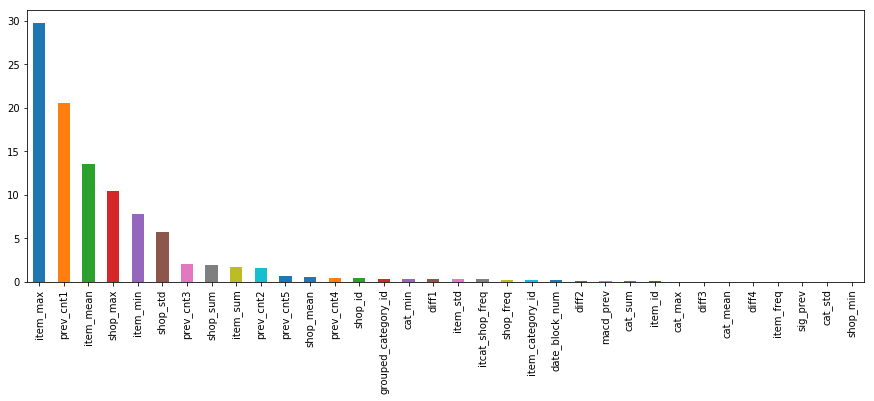

In [282]:
imp = cat_tuned.get_feature_importance(prettified=True)
features = [int(i[0].decode("utf-8")) for i in imp]
features = train[0].columns[features]
pd.Series(data = [i[1] for i in imp], index=features).plot(kind= 'bar')